In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Note: The following do not work with Python 3.12
import shap
# from ydata_profiling import ProfileReport
import sweetviz as sv

Reproducibility:

In [110]:
seed = 2024

# pandas, statsmodels, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
np.random.seed(seed)

In [4]:
diet = pd.read_csv('diet.csv', low_memory=False)
diet['Diet'] = diet['Diet'].astype('category')
diet

,AuthorId,Diet,Age
0,10000120E,Vegetarian,46
1,1000014D,Vegan,18
2,1000015A,Vegetarian,58
3,1000016E,Vegetarian,32
4,1000027E,Vegan,61
...,...,...,...
271902,999917E,Vegetarian,28
271903,999936C,Omnivore,22
271904,99993D,Vegetarian,58
271905,99994A,Vegetarian,18


Data Understanding

In [5]:
user_count= diet['AuthorId']
print(f'The number of author ids is: {user_count.size}')
print(f'The number of unique author ids is: {user_count.unique().size}')

The number of author ids is: 271907
The number of unique author ids is: 271907


Different Graphs of Diet.csv

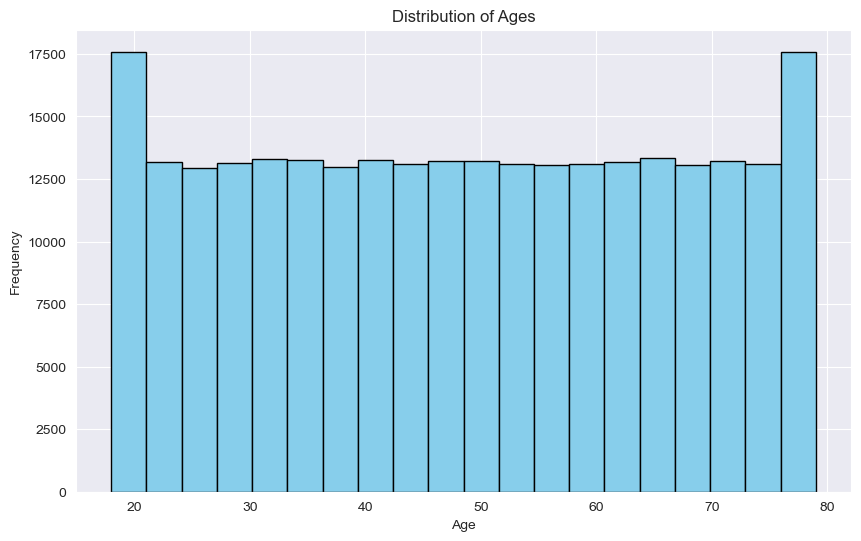

In [6]:
# Histogram of Ages
plt.figure(figsize=(10, 6))
plt.hist(diet['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


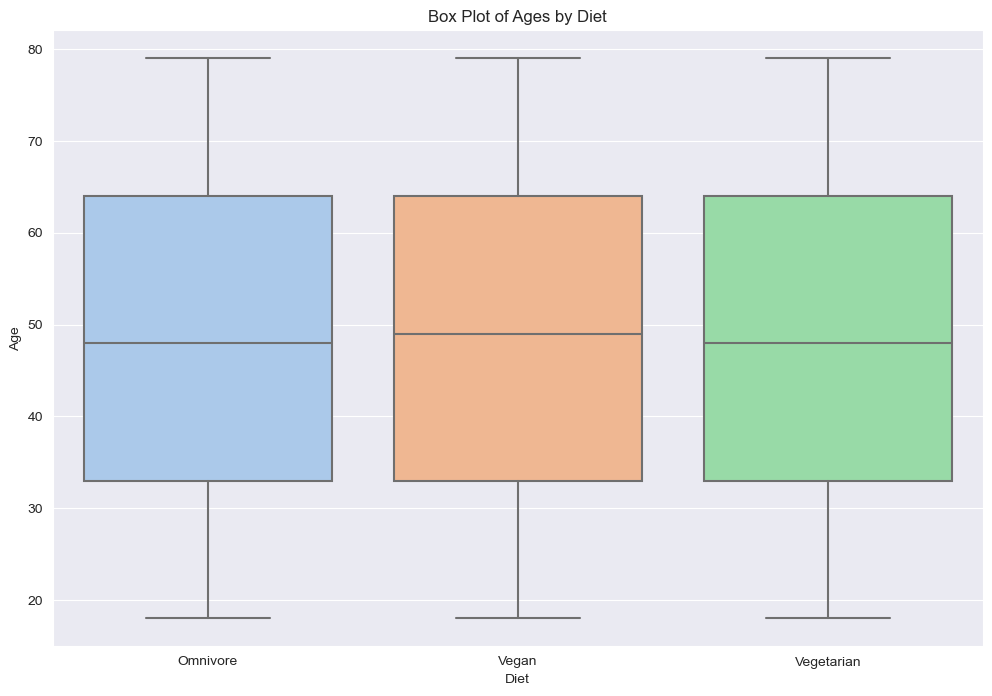

In [8]:
#Box Plot of Ages by Diet: Explore relationships between numerical variables (Age) using a pair plot.
plt.figure(figsize=(12, 8))
sns.boxplot(x='Diet', y='Age', data=diet, palette='pastel')
plt.title('Box Plot of Ages by Diet')
plt.xlabel('Diet')
plt.ylabel('Age')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


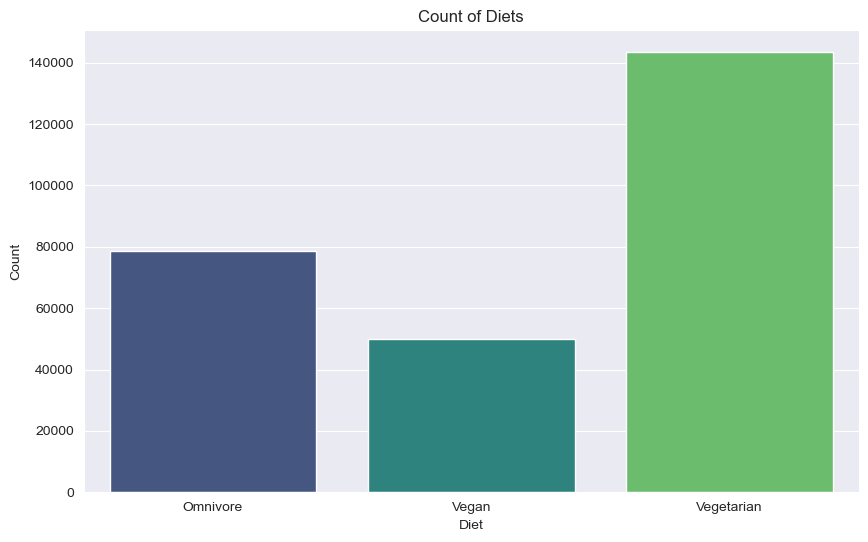

In [9]:
#Count Plot of Diets: Show the count of each diet category using a count plot.
plt.figure(figsize=(10, 6))
sns.countplot(x='Diet', data=diet, palette='viridis')
plt.title('Count of Diets')
plt.xlabel('Diet')
plt.ylabel('Count')
plt.show()

In [11]:
requests = pd.read_csv('requests.csv', low_memory=False)
requests['HighProtein'] = requests['HighProtein'].astype('category')
requests['LowSugar'] = requests['LowSugar'].astype('category')
requests

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1799.950949,0.0,Indifferent,0,0,0
1,437641B,365718,4201.820980,0.0,Yes,0,Indifferent,1
2,1803340263D,141757,6299.861496,0.0,Indifferent,1,Indifferent,0
3,854048B,280351,19801.365796,0.0,Yes,1,0,1
4,2277685E,180505,5400.093457,0.0,Indifferent,0,0,0
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1560.649725,0.0,Indifferent,0,0,1
140191,33888B,333262,1502.011466,1.0,Indifferent,1,0,0
140192,401942C,49200,5999.274269,0.0,Indifferent,0,0,1
140193,346866B,214815,899.523513,0.0,Yes,1,Indifferent,1


In [12]:
user_count= requests['AuthorId']
print("Author Id ")
print(f'The number of author ids is: {user_count.size}')
print(f'The number of unique author ids is: {user_count.unique().size}')
print(f'Author Diff: {user_count.size-user_count.unique().size}')
recipe_count= requests['RecipeId']
print("Recipe Id ")
print(f'The number of recipe ids is: {recipe_count.size}')
print(f'The number of unique recipe ids is: {recipe_count.unique().size}')
print(f'Recipe Diff: {recipe_count.size-recipe_count.unique().size}')

Author Id 
The number of author ids is: 140195
The number of unique author ids is: 49348
Author Diff: 90847
Recipe Id 
The number of recipe ids is: 140195
The number of unique recipe ids is: 75604
Recipe Diff: 64591


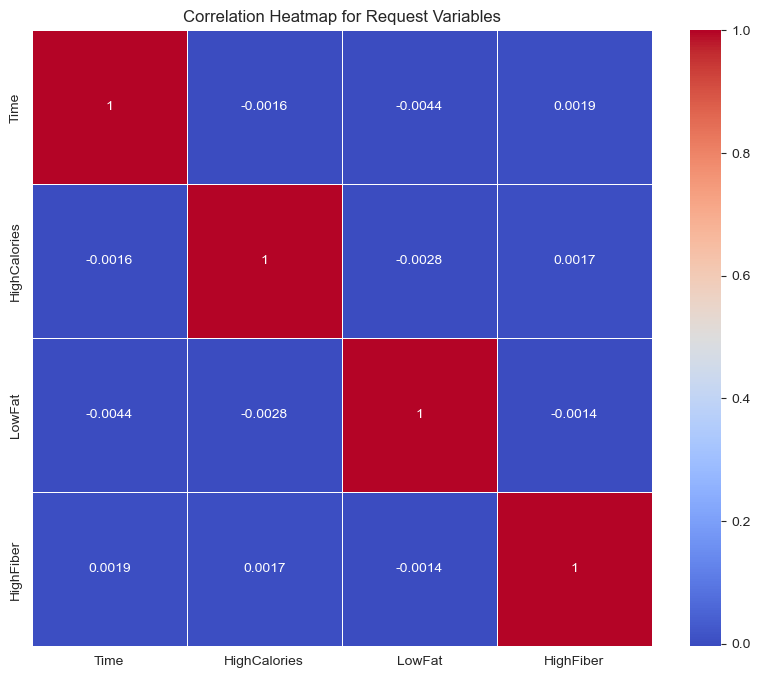

In [16]:
#Correlation Heatmap: Visualize the correlation between numerical variables.
# Exclude non-numeric columns
numeric_columns = requests[['Time', 'HighCalories', 'LowFat', 'HighFiber']]
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Request Variables')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


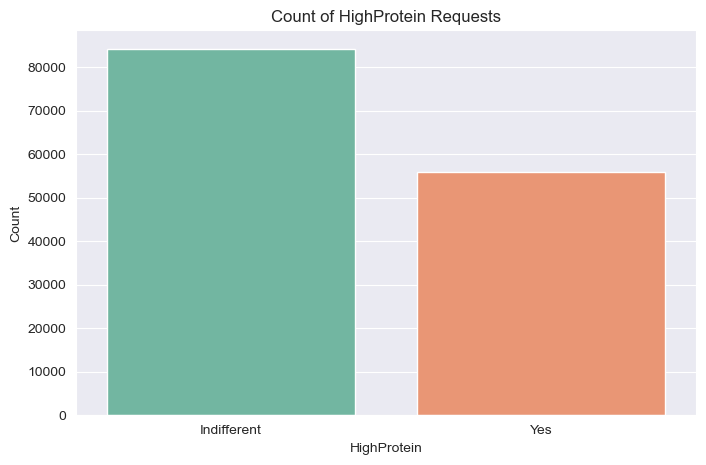

In [18]:
#Bar Plot of HighProtein Requests: Visualize the count of HighProtein requests.
plt.figure(figsize=(8, 5))
sns.countplot(x='HighProtein', data=requests, palette='Set2')
plt.title('Count of HighProtein Requests')
plt.xlabel('HighProtein')
plt.ylabel('Count')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


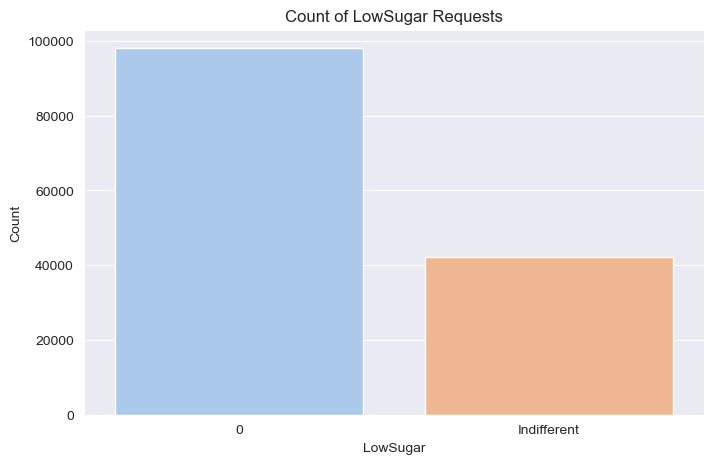

In [19]:
#Bar Plot of LowSugar Requests: Visualize the count of LowSugar requests.
plt.figure(figsize=(8, 5))
sns.countplot(x='LowSugar', data=requests, palette='pastel')
plt.title('Count of LowSugar Requests')
plt.xlabel('LowSugar')
plt.ylabel('Count')
plt.show()

In [20]:
reviews = pd.read_csv('reviews.csv', low_memory=False)
reviews

,AuthorId,RecipeId,Rating,Like,TestSetId
0,2492191A,33671,2.0,NaN,1.0
1,2002019979A,92647,2.0,NaN,2.0
2,408594E,161770,NaN,NaN,3.0
3,2001625557E,108231,2.0,NaN,4.0
4,2001427116E,71109,NaN,NaN,5.0
...,...,...,...,...,...
140190,999595E,338070,2.0,False,NaN
140191,999774A,29002,2.0,False,NaN
140192,999774A,159252,NaN,False,NaN
140193,999774A,1171,2.0,True,NaN


In [21]:
user1_count= reviews['AuthorId']
print("Author Id ")
print(f'The number of author ids is: {user1_count.size}')
print(f'The number of unique author ids is: {user1_count.unique().size}')
print(f'Author Diff: {user_count.size-user_count.unique().size}')
recipe1_count= reviews['RecipeId']
print("Recipe Id ")
print(f'The number of recipe ids is: {recipe1_count.size}')
print(f'The number of unique recipe ids is: {recipe1_count.unique().size}')
print(f'Recipe Diff: {recipe_count.size-recipe_count.unique().size}')

Author Id 
The number of author ids is: 140195
The number of unique author ids is: 49348
Author Diff: 90847
Recipe Id 
The number of recipe ids is: 140195
The number of unique recipe ids is: 75604
Recipe Diff: 64591


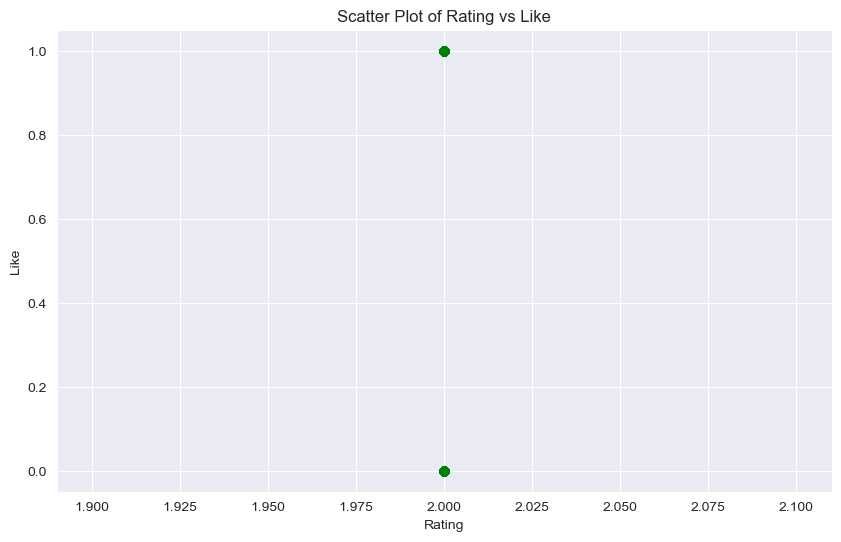

In [24]:
#Scatter Plot of Rating vs Like:Investigate the relationship between ratings and likes using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reviews['Rating'], reviews['Like'], alpha=0.5, color='green')
plt.title('Scatter Plot of Rating vs Like')
plt.xlabel('Rating')
plt.ylabel('Like')
plt.show()

In [29]:
recipes = pd.read_csv('recipes.csv', low_memory=False)
recipes.rename(columns={
    'Name': 'RecipeName'
}, inplace=True)
recipes

,RecipeId,RecipeName,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,8.0,NaN
2,141757,Copycat Taco Bell Nacho Fries BellGrande,3600,2700,Other,"c(""\""3\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\"""", ""\""3\""...","c(""\""Copycat Taco Bell Seasoned Beef\"""", ""\""ye...",377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,8.0,NaN
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,18000,1800,Other,"c(""\""2\"""", ""\""1\"""", ""\""2\"""", ""\""2\"""", ""\""1\"""",...","c(""\""unsalted butter\"""", ""\""yellow onion\"""", ""...",282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,6.0,NaN
4,180505,Cool & Crisp Citrus Chiffon Pie,3600,1800,Other,"c(""\""1\"""", ""\""1/4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\...","c(""\""unflavored gelatin\"""", ""\""water\"""", ""\""su...",257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,Frijoles Negros- Crock Pot Mexican Black Beans,43200,28800,Other,"c(""\""2\"""", ""\""6 -8\"""", ""\""5\"""", ""\""1/2\"""", ""\""...","c(""\""black beans\"""", ""\""water\"""", ""\""bay leave...",121.5,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,NaN,NaN
75600,267827,Moose Moussaka,3600,2700,Other,"c(""\""1\"""", ""\""6\"""", ""\""2\"""", ""\""2\"""", ""\""1/2\""...","c(""\""onion\"""", ""\""garlic cloves\"""", ""\""olive o...",652.2,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,NaN,NaN
75601,266983,Cantonese Pepper Steak for Two (Or More),1800,900,Other,"c(""\""1/2\"""", ""\""1\"""", ""\""1/8\"""", ""\""1/8\"""", ""\...","c(""\""top round steak\"""", ""\""cornstarch\"""", ""\""...",223.9,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,2.0,NaN
75602,253739,Coconut Cream Cooler,300,120,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""7 1/2\"""", ""\""1...","c(""\""cream of coconut\"""", ""\""water\"""")",2229.8,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,NaN,1 gallon


In [30]:
recipe1_count= recipes['RecipeId']
print("Recipe Id ")
print(f'The number of recipe ids is: {recipe1_count.size}')
print(f'The number of unique recipe ids is: {recipe1_count.unique().size}')

Recipe Id 
The number of recipe ids is: 75604
The number of unique recipe ids is: 75604


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


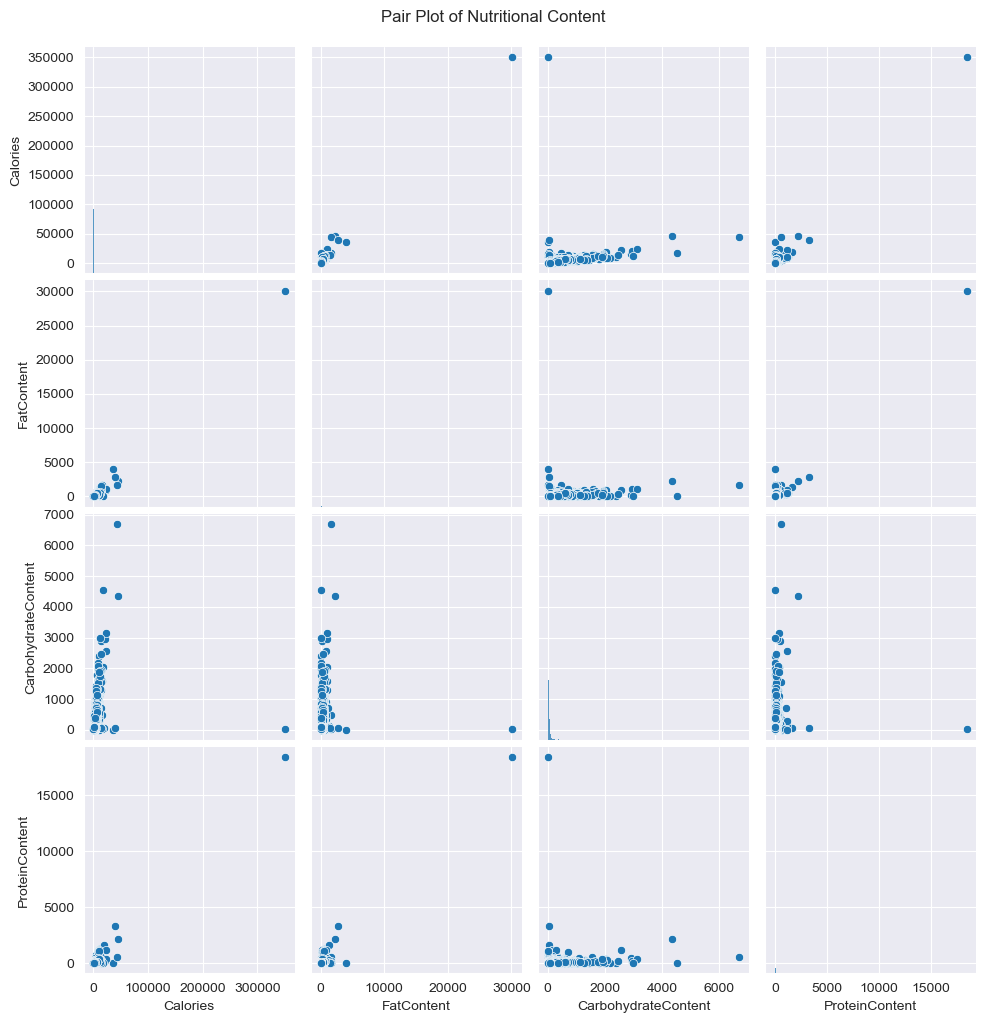

In [31]:
#Pair Plot for Nutritional Content:Explore relationships between nutritional content variables using a pair plot.
nutritional_content = recipes[['Calories', 'FatContent', 'CarbohydrateContent', 'ProteinContent']]
sns.pairplot(nutritional_content)
plt.suptitle('Pair Plot of Nutritional Content', y=1.02)
plt.show()

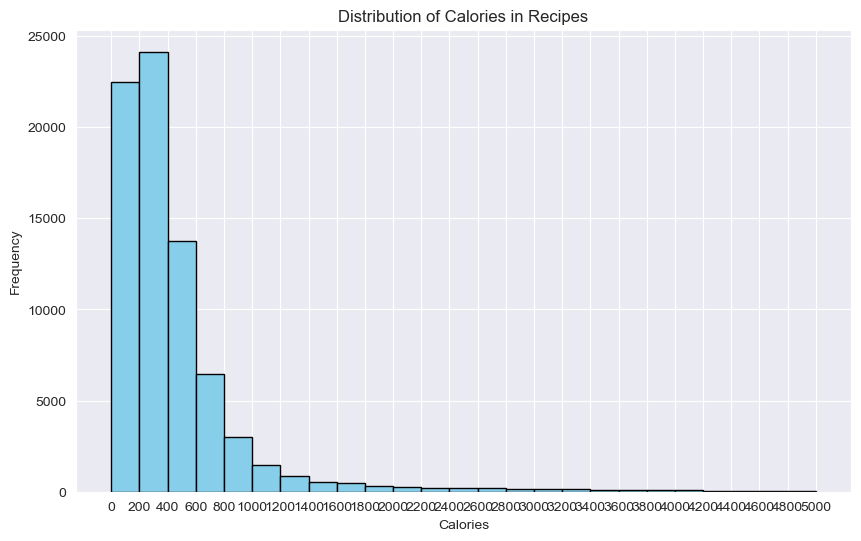

In [39]:
#Histogram for Calories:Explore the distribution of calories in recipes using a histogram.
custom_bins = np.arange(0, 5100, 200)  # Adjust the range and interval as needed

plt.figure(figsize=(10, 6))
plt.hist(recipes['Calories'], bins=custom_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Calories in Recipes')
plt.xlabel('Calories')
plt.ylabel('Frequency')

# Set x-axis labels
plt.xticks(custom_bins)

plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


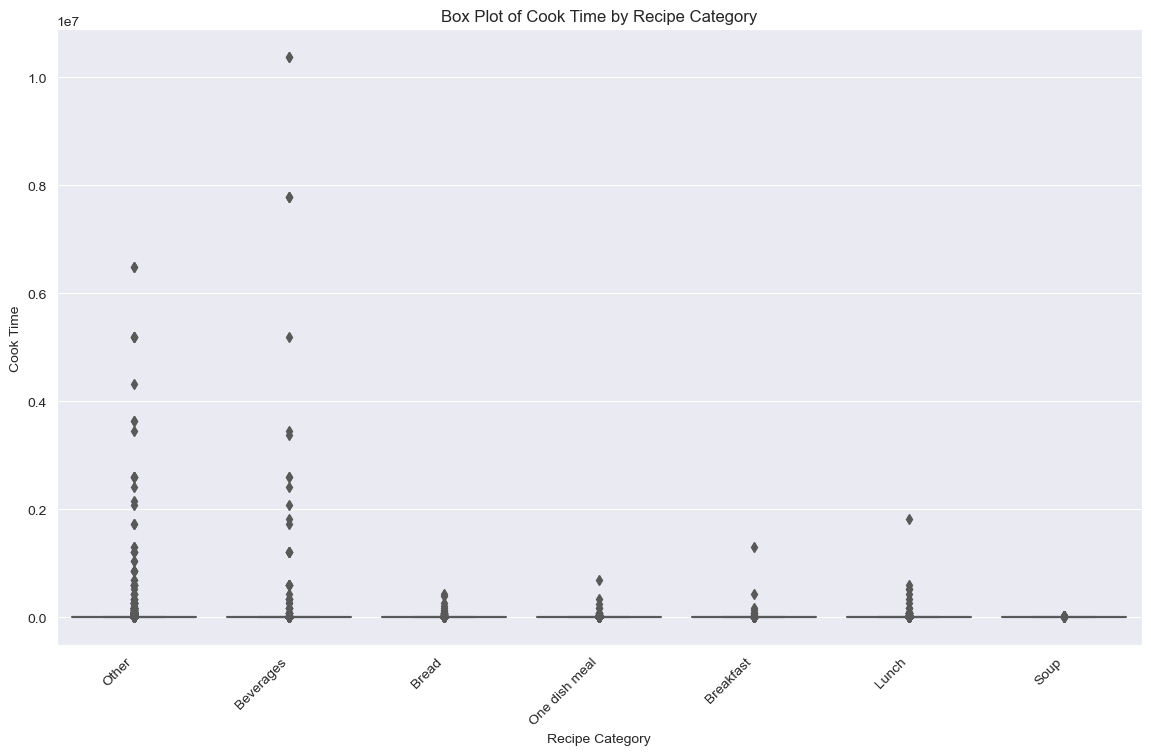

In [42]:
#Bar Plot for Recipe Categories: Visualize the distribution of recipes across different categories using a bar plot.
plt.figure(figsize=(14, 8))
sns.boxplot(x='RecipeCategory', y='CookTime', data=recipes, palette='Set2')
plt.title('Box Plot of Cook Time by Recipe Category')
plt.xlabel('Recipe Category')
plt.ylabel('Cook Time')
plt.xticks(rotation=45, ha='right')
plt.show()


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


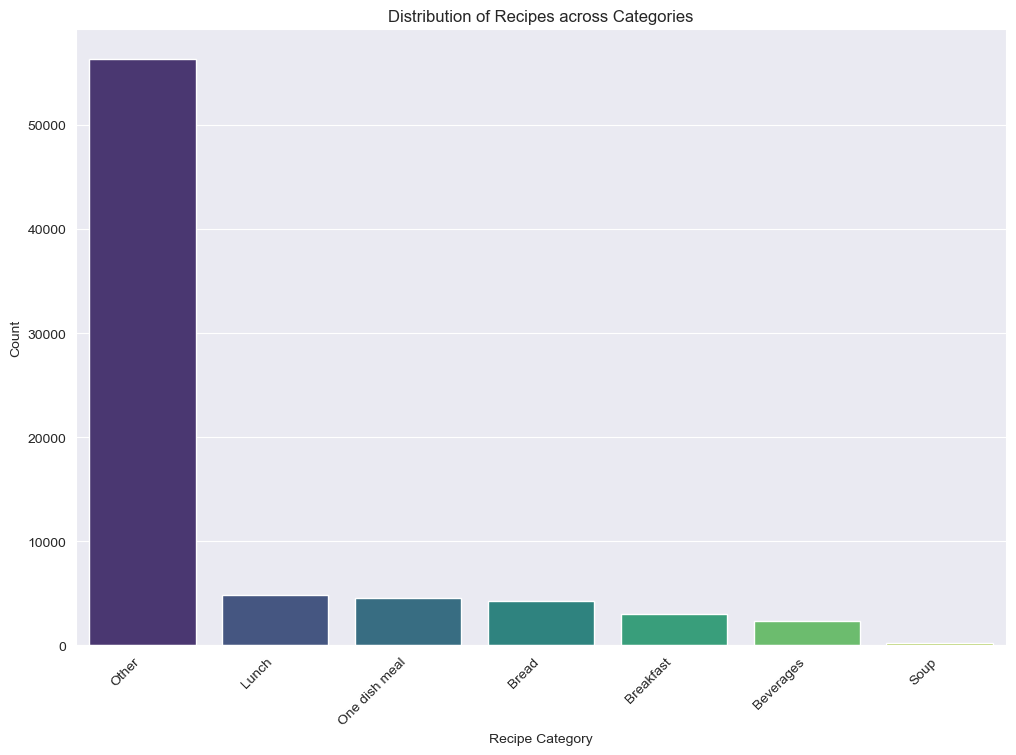

In [43]:
plt.figure(figsize=(12, 8))
sns.countplot(x='RecipeCategory', data=recipes, palette='viridis', order=recipes['RecipeCategory'].value_counts().index)
plt.title('Distribution of Recipes across Categories')
plt.xlabel('Recipe Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [119]:
merged_request_review = pd.merge(reviews,requests,on=['AuthorId','RecipeId'])
merged_request_review

,AuthorId,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2492191A,33671,2.0,NaN,1.0,2698.714376,0.0,Indifferent,1,0,1
1,2002019979A,92647,2.0,NaN,2.0,2399.694583,1.0,Indifferent,0,Indifferent,1
2,408594E,161770,NaN,NaN,3.0,2099.113170,1.0,Indifferent,0,0,1
3,2001625557E,108231,2.0,NaN,4.0,1199.645575,1.0,Yes,0,0,1
4,2001427116E,71109,NaN,NaN,5.0,2341.181827,1.0,Indifferent,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,2.0,False,NaN,3899.421310,0.0,Indifferent,1,Indifferent,0
140191,999774A,29002,2.0,False,NaN,2402.372535,0.0,Indifferent,0,Indifferent,0
140192,999774A,159252,NaN,False,NaN,5999.598903,0.0,Yes,0,0,0
140193,999774A,1171,2.0,True,NaN,480.233207,1.0,Yes,0,0,0


In [120]:
user1_count= merged_request_review['AuthorId']
print("Author Id ")
print(f'The number of author ids is: {user1_count.size}')
print(f'The number of unique author ids is: {user1_count.unique().size}')
print(f'Author Diff: {user_count.size-user_count.unique().size}')
recipe1_count= merged_request_review['RecipeId']
print("Recipe Id ")
print(f'The number of recipe ids is: {recipe1_count.size}')
print(f'The number of unique recipe ids is: {recipe1_count.unique().size}')
print(f'Recipe Diff: {recipe_count.size-recipe_count.unique().size}')

Author Id 
The number of author ids is: 140195
The number of unique author ids is: 49348
Author Diff: 90847
Recipe Id 
The number of recipe ids is: 140195
The number of unique recipe ids is: 75604
Recipe Diff: 64591


**CHECK** If a following recipe id exists and how many times and if the Recipe Id is mapped to the unique AuthorId 

In [121]:
recipe_id_to_check = merged_request_review['RecipeId'].value_counts().idxmax()

# Display the result
recipe_exists = merged_request_review['RecipeId'].isin([recipe_id_to_check])

# Display the result
if recipe_exists.any():
    # print(f"Recipe with RecipeId {recipe_id_to_check} exists.")
    recipe_count = merged_request_review['RecipeId'].value_counts().get(recipe_id_to_check, 0)
    print(f"Recipe with RecipeId {recipe_id_to_check} repeats {recipe_count} times.")
    # Get the table of corresponding AuthorId values for the given RecipeId
    author_id_table = merged_request_review.loc[merged_request_review['RecipeId'] == recipe_id_to_check, ['AuthorId','RecipeId']]
    print("Table of AuthorId values for RecipeId", recipe_id_to_check)
    print()
    
else:
    print(f"Recipe with RecipeId {recipe_id_to_check} does not exist.")

author_id_table    

Recipe with RecipeId 45809 repeats 258 times.
Table of AuthorId values for RecipeId 45809


,AuthorId,RecipeId
63,2002602259D,45809
1675,864207D,45809
2153,2001559569B,45809
3501,1802473053B,45809
3704,337907B,45809
...,...,...
137190,903531E,45809
138317,931429E,45809
138676,939545E,45809
139653,978808D,45809


In [122]:
unique_recipe_ids_from_merge = merged_request_review['RecipeId'].unique()
unique_recipe_ids_from_recipes = recipes['RecipeId'].unique()
are_ids_equal = set(unique_recipe_ids_from_recipes) == set(unique_recipe_ids_from_merge)

if are_ids_equal:
    print("The unique RecipeId values are the same in both DataFrames.")
else:
    print("The unique RecipeId values are not the same in both DataFrames.")

# # Assuming merged_request_review is the result of merging reviews and requests DataFrames
# # using pd.merge(reviews, requests, on=['AuthorId', 'RecipeId'])
# 
# # Get the unique RecipeId values
# unique_recipe_ids = merged_request_review['RecipeId'].unique()
# 
# # Initialize a list to store the uniqueness result for each RecipeId
# uniqueness_results = []
# 
# # Iterate over unique RecipeId values
# for recipe_id in unique_recipe_ids:
#     # Get the table of corresponding AuthorId values for the given RecipeId
#     author_id_table = merged_request_review.loc[merged_request_review['RecipeId'] == recipe_id, ['AuthorId', 'RecipeId']]
# 
#     # Check if the mapped AuthorId values are unique
#     is_author_id_unique = ~author_id_table['AuthorId'].duplicated().any()
# 
#     uniqueness_results.append((recipe_id, is_author_id_unique))
# 
# # Create a DataFrame from the results
# uniqueness_df = pd.DataFrame(uniqueness_results, columns=['RecipeId', 'IsAuthorIdUnique'])
# 
# # Display the DataFrame
# print(uniqueness_df)
# # 
# # Visualization: Bar plot of unique AuthorId counts for each RecipeId
# uniqueness_df.set_index('RecipeId')['IsAuthorIdUnique'].astype(int).plot(kind='bar', xlabel='RecipeId', ylabel='IsAuthorIdUnique (1: True, 0: False)', title='Uniqueness of AuthorId for Each RecipeId')
# plt.show()

The unique RecipeId values are the same in both DataFrames.


In [123]:
merged_recipes_req_review= pd.merge(merged_request_review,recipes,on=['RecipeId'],how='right')
merged_recipes_req_review

,AuthorId,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,LowFat,LowSugar,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,914496A,73440,NaN,NaN,1548.0,1800.709345,0.0,Indifferent,0,0,...,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
1,2668181C,73440,2.0,NaN,2069.0,1797.825626,0.0,Yes,0,Indifferent,...,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
2,2000237272A,73440,2.0,NaN,2152.0,1800.440504,1.0,Indifferent,0,0,...,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
3,2001895110E,73440,NaN,NaN,3293.0,1799.437007,0.0,Indifferent,0,0,...,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
4,1800347124D,73440,NaN,NaN,4621.0,1801.007172,1.0,Yes,0,0,...,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,1677720D,253577,2.0,True,NaN,71998.977353,0.0,Indifferent,1,Indifferent,...,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,NaN,NaN
140191,853126B,267827,NaN,NaN,7148.0,6299.278484,0.0,Yes,1,0,...,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,NaN,NaN
140192,2000154789A,266983,2.0,True,NaN,2700.812133,0.0,Yes,0,0,...,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,2.0,NaN
140193,499207A,253739,2.0,True,NaN,419.558713,1.0,Indifferent,0,Indifferent,...,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,NaN,1 gallon


Changing the object data types

Data Joining using common attributes

In [124]:
author_ID = 'AuthorId'
merged_diet_all = pd.merge(diet, merged_recipes_req_review, on=author_ID, how='left')
# merged_request_recipes = pd.merge(requests, recipes, on='RecipeId', how='left')
merged_diet_all

,AuthorId,Diet,Age,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,10000120E,Vegetarian,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000014D,Vegan,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000015A,Vegetarian,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000016E,Vegetarian,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000027E,Vegan,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362749,999917E,Vegetarian,28,169413.0,2.0,False,NaN,3600.387748,0.0,Indifferent,...,8.6,4.7,66.5,521.9,24.8,1.7,3.4,5.6,8.0,NaN
362750,999936C,Omnivore,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362751,99993D,Vegetarian,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362752,99994A,Vegetarian,18,373964.0,NaN,NaN,7555.0,7199.509521,0.0,Yes,...,0.2,0.0,0.0,5.6,36.2,0.2,33.6,0.2,16.0,3 quarts


Plot graphs of the data frames

Impute the missing values

In [125]:
# 1 value missing in diet column. Filled with most occuring value.
merged_diet_all['Diet'] = merged_diet_all['Diet'].fillna('Vegetarian')

In [126]:
#impute the values for all dietary preferences for all ages with the most frequent RecipeId for that age in that category
helper_df = merged_diet_all.groupby(['Age', 'Diet'])['RecipeId'].agg(lambda x: x.mode()[0]).reset_index()
helper_df.columns = ['Age', 'Diet', 'Most Common Recipe']
def impute_recipe(row):
    if pd.isnull(row['RecipeId']):
        return helper_df[(helper_df['Age'] == row['Age']) & (helper_df['Diet'] == row['Diet'])]['Most Common Recipe'].values[0]
    else:
        return row['RecipeId']
merged_diet_all['RecipeId'] = merged_diet_all.apply(impute_recipe, axis=1)
merged_diet_all

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,AuthorId,Diet,Age,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,10000120E,Vegetarian,46,2886.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000014D,Vegan,18,11194.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000015A,Vegetarian,58,45809.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000016E,Vegetarian,32,150863.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000027E,Vegan,61,64446.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362749,999917E,Vegetarian,28,169413.0,2.0,False,NaN,3600.387748,0.0,Indifferent,...,8.6,4.7,66.5,521.9,24.8,1.7,3.4,5.6,8.0,NaN
362750,999936C,Omnivore,22,15072.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362751,99993D,Vegetarian,58,45809.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362752,99994A,Vegetarian,18,373964.0,NaN,NaN,7555.0,7199.509521,0.0,Yes,...,0.2,0.0,0.0,5.6,36.2,0.2,33.6,0.2,16.0,3 quarts


In [127]:
# Fill the rest of the missing values in the merged_diet_all by mapping them from requests.csv with RecipeId as key 
# Create mapping DataFrames from `requests`
map_time = requests.set_index('RecipeId')['Time'].to_dict()
map_calories = requests.set_index('RecipeId')['HighCalories'].to_dict()
map_protein = requests.set_index('RecipeId')['HighProtein'].to_dict()
map_fat = requests.set_index('RecipeId')['LowFat'].to_dict()
map_sugar = requests.set_index('RecipeId')['LowSugar'].to_dict()
map_fiber = requests.set_index('RecipeId')['HighFiber'].to_dict()

# Apply mapping to `merged_diet_all`
merged_diet_all['Time'] = merged_diet_all['RecipeId'].map(map_time)
merged_diet_all['HighCalories'] = merged_diet_all['RecipeId'].map(map_calories)
merged_diet_all['HighProtein'] = merged_diet_all['RecipeId'].map(map_protein)
merged_diet_all['LowFat'] = merged_diet_all['RecipeId'].map(map_fat)
merged_diet_all['LowSugar'] = merged_diet_all['RecipeId'].map(map_sugar)
merged_diet_all['HighFiber'] = merged_diet_all['RecipeId'].map(map_fiber)
merged_diet_all    

,AuthorId,Diet,Age,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,10000120E,Vegetarian,46,2886.0,NaN,NaN,NaN,4198.933093,1.0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000014D,Vegan,18,11194.0,NaN,NaN,NaN,600.014974,0.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000015A,Vegetarian,58,45809.0,NaN,NaN,NaN,14399.381563,1.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000016E,Vegetarian,32,150863.0,NaN,NaN,NaN,3600.420005,0.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000027E,Vegan,61,64446.0,NaN,NaN,NaN,2099.032638,0.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362749,999917E,Vegetarian,28,169413.0,2.0,False,NaN,3600.387748,0.0,Indifferent,...,8.6,4.7,66.5,521.9,24.8,1.7,3.4,5.6,8.0,NaN
362750,999936C,Omnivore,22,15072.0,NaN,NaN,NaN,2280.037298,0.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362751,99993D,Vegetarian,58,45809.0,NaN,NaN,NaN,14399.381563,1.0,Indifferent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362752,99994A,Vegetarian,18,373964.0,NaN,NaN,7555.0,7199.509521,0.0,Yes,...,0.2,0.0,0.0,5.6,36.2,0.2,33.6,0.2,16.0,3 quarts


Impute value from recipe.csv

In [128]:
map_name = recipes.set_index('RecipeId')['RecipeName'].to_dict()
map_cook_time = recipes.set_index('RecipeId')['CookTime'].to_dict()
map_prep_time = recipes.set_index('RecipeId')['PrepTime'].to_dict()
map_category = recipes.set_index('RecipeId')['RecipeCategory'].to_dict()
map_quantities = recipes.set_index('RecipeId')['RecipeIngredientQuantities'].to_dict()
map_parts = recipes.set_index('RecipeId')['RecipeIngredientParts'].to_dict()
map_calories = recipes.set_index('RecipeId')['Calories'].to_dict()
map_fat_content = recipes.set_index('RecipeId')['FatContent'].to_dict()
map_saturated_content = recipes.set_index('RecipeId')['SaturatedFatContent'].to_dict()
map_cholesterol = recipes.set_index('RecipeId')['CholesterolContent'].to_dict()
map_sodium = recipes.set_index('RecipeId')['SodiumContent'].to_dict()
map_carbohydrate = recipes.set_index('RecipeId')['CarbohydrateContent'].to_dict()
map_fiber = recipes.set_index('RecipeId')['FiberContent'].to_dict()
map_sugar = recipes.set_index('RecipeId')['SugarContent'].to_dict()
map_protein = recipes.set_index('RecipeId')['ProteinContent'].to_dict()
map_servings = recipes.set_index('RecipeId')['RecipeServings'].to_dict()
map_yield = recipes.set_index('RecipeId')['RecipeYield'].to_dict()


# Apply mapping to `merged_diet_all`
merged_diet_all['RecipeName'] = merged_diet_all['RecipeId'].map(map_name)
merged_diet_all['CookTime'] = merged_diet_all['RecipeId'].map(map_cook_time)
merged_diet_all['PrepTime'] = merged_diet_all['RecipeId'].map(map_prep_time)
merged_diet_all['RecipeCategory'] = merged_diet_all['RecipeId'].map(map_category)
merged_diet_all['RecipeIngredientQuantities'] = merged_diet_all['RecipeId'].map(map_quantities)
merged_diet_all['RecipeIngredientParts'] = merged_diet_all['RecipeId'].map(map_parts)
merged_diet_all['Calories'] = merged_diet_all['RecipeId'].map(map_calories)
merged_diet_all['FatContent'] = merged_diet_all['RecipeId'].map(map_fat)
merged_diet_all['SaturatedFatContent'] = merged_diet_all['RecipeId'].map(map_saturated_content)
merged_diet_all['CholesterolContent'] = merged_diet_all['RecipeId'].map(map_cholesterol)
merged_diet_all['SodiumContent'] = merged_diet_all['RecipeId'].map(map_sodium)
merged_diet_all['CarbohydrateContent'] = merged_diet_all['RecipeId'].map(map_carbohydrate)
merged_diet_all['FiberContent'] = merged_diet_all['RecipeId'].map(map_fiber)
merged_diet_all['SugarContent'] = merged_diet_all['RecipeId'].map(map_sugar)
merged_diet_all['ProteinContent'] = merged_diet_all['RecipeId'].map(map_protein)
merged_diet_all['RecipeServings'] = merged_diet_all['RecipeId'].map(map_servings)
merged_diet_all['RecipeYield'] = merged_diet_all['RecipeId'].map(map_yield)

**CHECK IF IT WORKS**

In [129]:
merged_diet_all['Rating'] = merged_diet_all['Rating'].fillna(0)
merged_diet_all['TestSetId'] = merged_diet_all['TestSetId'].fillna(0)
merged_diet_all

,AuthorId,Diet,Age,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,10000120E,Vegetarian,46,2886.0,0.0,NaN,0.0,4198.933093,1.0,Yes,...,1,2.8,32.6,255.3,40.6,1.0,10.2,7.3,10.0,1 large loaf
1,1000014D,Vegan,18,11194.0,0.0,NaN,0.0,600.014974,0.0,Indifferent,...,0,0.4,2.5,34.0,37.9,2.9,25.4,3.1,4.0,NaN
2,1000015A,Vegetarian,58,45809.0,0.0,NaN,0.0,14399.381563,1.0,Indifferent,...,0,29.5,448.7,1221.0,52.1,1.5,36.9,119.0,8.0,NaN
3,1000016E,Vegetarian,32,150863.0,0.0,NaN,0.0,3600.420005,0.0,Indifferent,...,0,2.2,114.3,65.0,14.2,0.0,11.4,5.2,NaN,1 bowl (varies)
4,1000027E,Vegan,61,64446.0,0.0,NaN,0.0,2099.032638,0.0,Indifferent,...,0,4.5,46.6,754.8,18.2,4.4,7.3,27.7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362749,999917E,Vegetarian,28,169413.0,2.0,False,0.0,3600.387748,0.0,Indifferent,...,0,4.7,66.5,521.9,24.8,1.7,3.4,5.6,8.0,NaN
362750,999936C,Omnivore,22,15072.0,0.0,NaN,0.0,2280.037298,0.0,Indifferent,...,0,1.6,115.2,1227.3,5.6,0.3,3.1,15.8,NaN,20-25 shrimp
362751,99993D,Vegetarian,58,45809.0,0.0,NaN,0.0,14399.381563,1.0,Indifferent,...,0,29.5,448.7,1221.0,52.1,1.5,36.9,119.0,8.0,NaN
362752,99994A,Vegetarian,18,373964.0,0.0,NaN,7555.0,7199.509521,0.0,Yes,...,0,0.0,0.0,5.6,36.2,0.2,33.6,0.2,16.0,3 quarts


In [132]:
final_data = merged_diet_all
final_data['AuthorId'], unique_authorids = pd.factorize(final_data['AuthorId'])

final_data

,AuthorId,Diet,Age,RecipeId,Rating,Like,TestSetId,Time,HighCalories,HighProtein,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
0,0,Vegetarian,46,2886.0,0.0,NaN,0.0,4198.933093,1.0,Yes,...,1,2.8,32.6,255.3,40.6,1.0,10.2,7.3,10.0,1 large loaf
1,1,Vegan,18,11194.0,0.0,NaN,0.0,600.014974,0.0,Indifferent,...,0,0.4,2.5,34.0,37.9,2.9,25.4,3.1,4.0,NaN
2,2,Vegetarian,58,45809.0,0.0,NaN,0.0,14399.381563,1.0,Indifferent,...,0,29.5,448.7,1221.0,52.1,1.5,36.9,119.0,8.0,NaN
3,3,Vegetarian,32,150863.0,0.0,NaN,0.0,3600.420005,0.0,Indifferent,...,0,2.2,114.3,65.0,14.2,0.0,11.4,5.2,NaN,1 bowl (varies)
4,4,Vegan,61,64446.0,0.0,NaN,0.0,2099.032638,0.0,Indifferent,...,0,4.5,46.6,754.8,18.2,4.4,7.3,27.7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362749,271902,Vegetarian,28,169413.0,2.0,False,0.0,3600.387748,0.0,Indifferent,...,0,4.7,66.5,521.9,24.8,1.7,3.4,5.6,8.0,NaN
362750,271903,Omnivore,22,15072.0,0.0,NaN,0.0,2280.037298,0.0,Indifferent,...,0,1.6,115.2,1227.3,5.6,0.3,3.1,15.8,NaN,20-25 shrimp
362751,271904,Vegetarian,58,45809.0,0.0,NaN,0.0,14399.381563,1.0,Indifferent,...,0,29.5,448.7,1221.0,52.1,1.5,36.9,119.0,8.0,NaN
362752,271905,Vegetarian,18,373964.0,0.0,NaN,7555.0,7199.509521,0.0,Yes,...,0,0.0,0.0,5.6,36.2,0.2,33.6,0.2,16.0,3 quarts


Data Visualization

Random Forest Classifier

In [130]:
# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [131]:
# Step 2: Load cleaned data
def load_cleaned_data():
    # Replace this function with your data loading and cleaning logic
    # Example assumes X contains features and y contains labels
    data = pd.read_csv('cleaned_data.csv') # can also pass a data frame
    X = data.drop('target_column', axis=1)
    y = data['target_column']
    return X, y

X, y = load_cleaned_data()

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.csv'

In [ ]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Choose a Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Step 5: Train the model
rf_model.fit(X_train, y_train)

In [ ]:
# Step 6: Make predictions on the test set
predictions = rf_model.predict(X_test)

In [ ]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")